In [1]:
# import packages 导入库，搭建环境
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings 可以删除
import warnings
warnings.filterwarnings('ignore')

# 为了让matplotlib里显示中文字符
import matplotlib.font_manager as fm 
matplotlib.rcParams['font.family'] = 'Microsoft Yahei' # 设置字体

In [2]:
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from mlxtend.classifier import EnsembleVoteClassifier

In [32]:
def train_data_from_frame_voting(clf, a):
    eclf=EnsembleVoteClassifier(clfs=clf,voting='soft',weights=a,fit_base_estimators=False)
    eclf=eclf.fit(X=X_train,y=y_train)
    y_score=eclf.predict_proba(X_test)[:,1]
    #print y_score.max(),y_score.min()
    y_predict = eclf.predict(X_test)
    #print y_predict
    print ("vote_accuracy_score:", accuracy_score(y_test, y_predict))
    print ("vote_precision_score:", precision_score(y_test, y_predict))
    print ("vote_recall_score:", recall_score(y_test, y_predict))
    print ("vote_f1_score:", f1_score(y_test, y_predict))
    print ("vote_roc_score:", roc_auc_score(y_test, y_score))
    cm = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title('Vote')

In [3]:
df = pd.read_csv('保单数据.csv')

In [56]:
df.describe()

,事故月中周数,出险月中周数,出险人年龄,是否骗保,保单编号,客服编号,起付额,驾驶员评级,事故年份
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,2017.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,2017.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,2017.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,2018.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,2019.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,2019.000000


In [5]:
target = ['是否骗保']
feature = ['事故月份',
 '事故月中周数',
 '事故周中天数',
 '品牌',
 '事故发生区域',
 '出险周中天数',
 '出险月份',
 '出险月中周数',
 '出险人性别',
 '出险人婚姻状况',
 '出险人年龄',
 '责任划分',
 '保单类别',
 '车辆类别',
 '车辆价格',
 '起付额',
 '驾驶员评级',
 '事故距离保单生效天数',
 '出险距离保单生效天数',
 '历史出险次数',
 '车龄',
 '投保人年龄',
 '是否出警',
 '是否有目击者',
 '中介类型',
 '补充出险次数',
 '出险距离地址变动时间',
 '投保人车辆数',
 '事故年份',
 '车险类别']
df1 = pd.get_dummies(df[feature])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df1, df[target], test_size=0.3)

In [38]:
clf1=BaggingClassifier(GaussianNB(), random_state=42)
clf2=GaussianNB()
clf3=BaggingClassifier(LogisticRegression(penalty='l2'), random_state=42)
clf4=LogisticRegression(penalty='l2')
clf5=AdaBoostClassifier(random_state=42, learning_rate = 1, n_estimators= 500)
clf6=xgb.XGBClassifier(random_state=42, learning_rate = 1, max_depth= 3, n_estimators= 500)
clf7=RandomForestClassifier(random_state=42)

In [121]:
params = { # 通过网格搜索，寻找最优参数
    "n_estimators": [3, 5, 7, 10],
    "max_depth": [10, 20, 30, 50],
}

In [122]:
xgb_classifier = GridSearchCV( # 初始化网格搜索
    estimator = clf5, # 模型
    param_grid = params, # 参数
    scoring = 'f1', # 评价指标
    cv = 5 # 交叉验证折数
)

In [123]:
xgb_classifier.fit(X_train, y_train)
print(xgb_classifier.best_params_)

{'max_depth': 30, 'n_estimators': 3}


accuracy_score: 0.444444 [navie Bayes bagging]
precision_score: 0.096603 [navie Bayes bagging]
recall_score: 0.941379 [navie Bayes bagging]
f1_score: 0.175225 [navie Bayes bagging]
auc_score: 0.770874 [navie Bayes bagging]


accuracy_score: 0.496109 [navie Bayes]
precision_score: 0.104611 [navie Bayes]
recall_score: 0.931034 [navie Bayes]
f1_score: 0.188088 [navie Bayes]
auc_score: 0.762471 [navie Bayes]


accuracy_score: 0.937311 [Logistic bagging]
precision_score: 0.000000 [Logistic bagging]
recall_score: 0.000000 [Logistic bagging]
f1_score: 0.000000 [Logistic bagging]
auc_score: 0.789210 [Logistic bagging]


accuracy_score: 0.937311 [Logistic]
precision_score: 0.000000 [Logistic]
recall_score: 0.000000 [Logistic]
f1_score: 0.000000 [Logistic]
auc_score: 0.786473 [Logistic]


accuracy_score: 0.932555 [adaboost]
precision_score: 0.156250 [adaboost]
recall_score: 0.017241 [adaboost]
f1_score: 0.031056 [adaboost]
auc_score: 0.783185 [adaboost]


accuracy_score: 0.918288 [xgboost]
preci

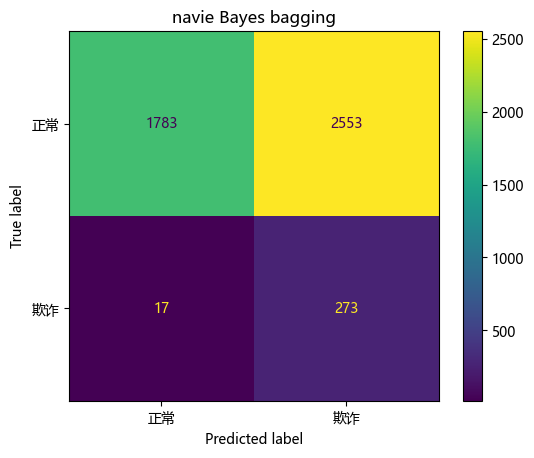

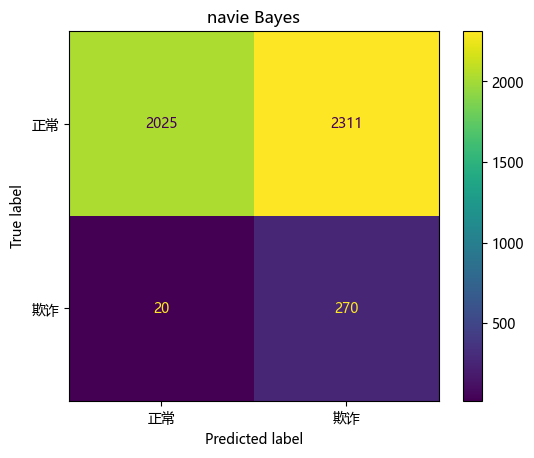

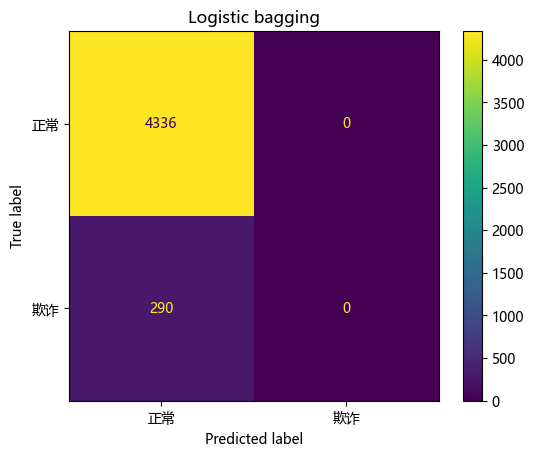

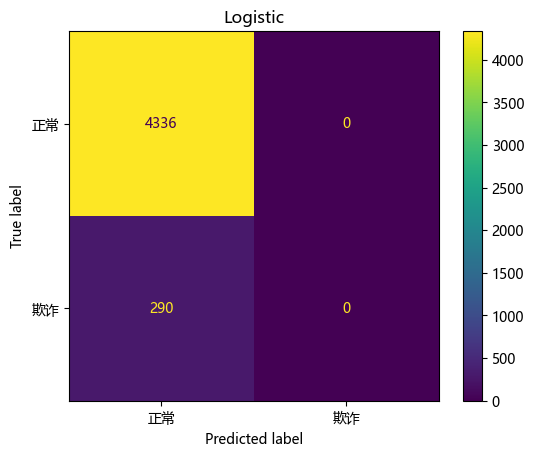

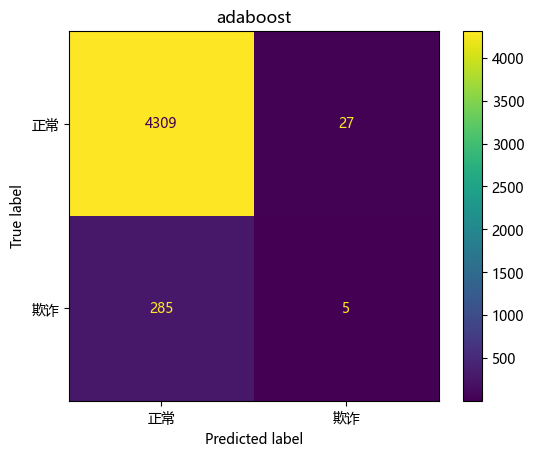

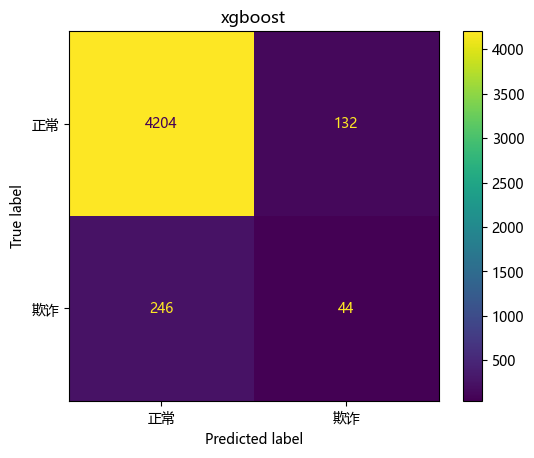

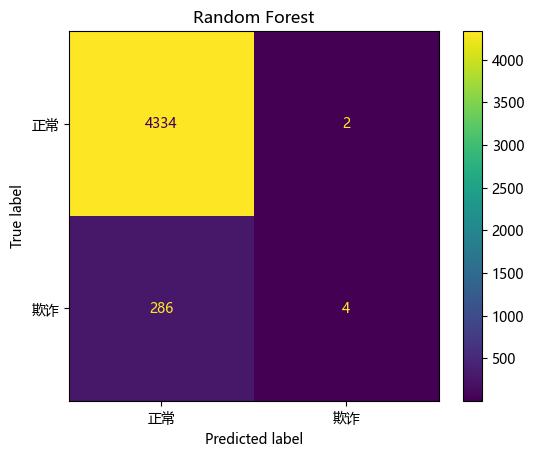

In [40]:
for clf,label in zip([clf1,clf2,clf3,clf4,clf5,clf6,clf7],
                     ['navie Bayes bagging','navie Bayes','Logistic bagging','Logistic',
                                                'adaboost','xgboost','Random Forest']):
    clf=clf.fit(X=X_train,y=y_train)
    score=clf.predict_proba(X_test)[:,1]
    y_pred=clf.predict(X_test)
    
    #auc=cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
    #accuracy=cross_val_score(clf,X,y,cv=5,scoring='accuracy')
    #precision=cross_val_score(clf,X,y,cv=5,scoring='precision')
    #recall=cross_val_score(clf,X,y,cv=5,scoring='recall')

    #print ('auc: %0.2f (+/- %0.2f) [%s]' %(auc.mean(), auc.std(), label))
    #print ('accuracy: %0.2f (+/- %0.2f) [%s]' %(accuracy.mean(), accuracy.std(), label))
    #print ('precision: %0.2f (+/- %0.2f) [%s]' %(precision.mean(), precision.std(), label))
    #print ('recall: %0.2f (+/- %0.2f) [%s]' %(recall.mean(), recall.std(), label))
    print('accuracy_score: %f [%s]' %(accuracy_score(y_test, y_pred), label))
    print('precision_score: %f [%s]' %(precision_score(y_test, y_pred), label))
    print('recall_score: %f [%s]' %(recall_score(y_test, y_pred), label))
    print('f1_score: %f [%s]' %(f1_score(y_test, y_pred), label))
    print('auc_score: %f [%s]' %(roc_auc_score(y_test, score), label))
    print("\n")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title(label)



vote_accuracy_score: 0.7542153047989624
vote_precision_score: 0.16784313725490196
vote_recall_score: 0.7379310344827587
vote_f1_score: 0.27348242811501594
vote_roc_score: 0.8137374347881411


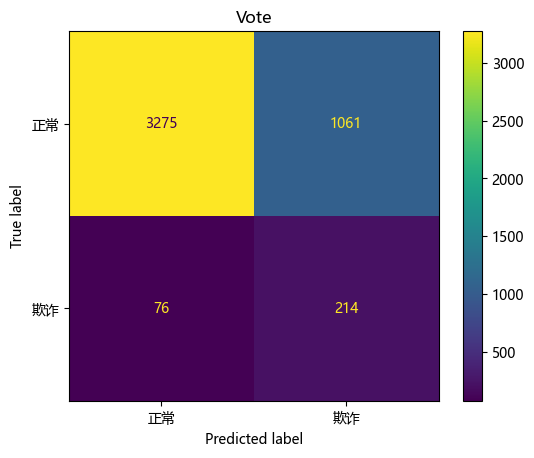

In [41]:
train_data_from_frame_voting([clf1, clf5, clf6], [1, 1, 1])

vote_accuracy_score: 0.604842196281885
vote_precision_score: 0.12432697014194811
vote_recall_score: 0.8668941979522184
vote_f1_score: 0.21746575342465754
vote_roc_score: 0.7893127510202281


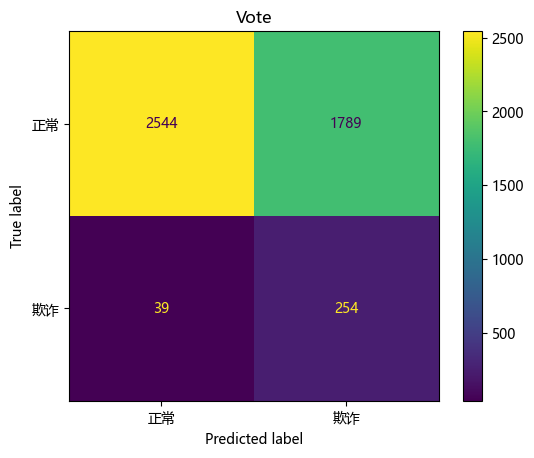

In [11]:
train_data_from_frame_voting([1, 0, 1])

vote_accuracy_score: 0.6074362300043233
vote_precision_score: 0.128717698683569
vote_recall_score: 0.9010238907849829
vote_f1_score: 0.22525597269624573
vote_roc_score: 0.7719155083339307


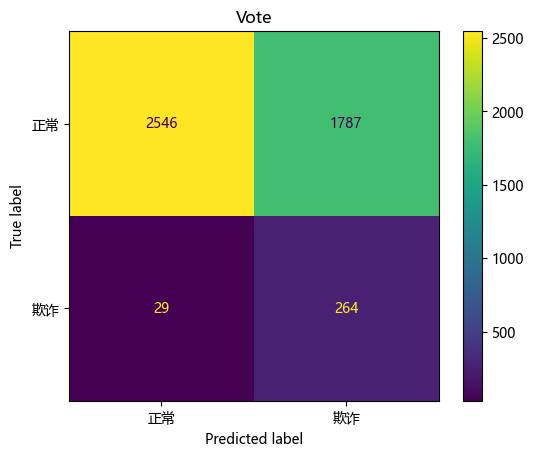

In [12]:
train_data_from_frame_voting([1, 200, 0])

In [52]:
clf1.estimators_[0].n_features_in_

144

In [55]:
pd.Series(index = df1.columns, data=clf1.estimators_[0].theta_[0])

事故月中周数          2.782890
出险月中周数          2.661042
出险人年龄          39.810654
起付额           407.397233
驾驶员评级           2.478956
                 ...    
投保人车辆数_5-8      0.001472
投保人车辆数_大于8      0.000196
车险类别_全险         0.274502
车险类别_第三者险       0.337487
车险类别_车损险        0.388011
Length: 144, dtype: float64

In [95]:
print(pd.Series(clf4.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).to_string())

责任划分_出险人               16.503914
车险类别_第三者险              15.163332
出险距离地址变动时间_2-3年         5.045979
出险距离保单生效天数_15 to 30     4.007532
事故年份                    2.396032
保单类别_轿车-车损险             2.064885
投保人年龄_21-25岁            1.629015
保单类别_轿车-第三者险            1.616557
事故月份_五月                 1.568867
投保人车辆数_1                1.524527
车辆类别_跑车                 1.474962
投保人年龄_31-35岁            1.459260
品牌_讴歌                   1.446994
出险月份_九月                 1.419835
车辆类别_SUV                1.407102
出险周中天数_周一               1.340317
事故月份_二月                 1.320224
补充出险次数_1-2次             1.303355
出险月份_十二月                1.299823
出险月份_十月                 1.294424
品牌_道奇                   1.269614
出险月份_十一月                1.264560
投保人年龄_41-50岁            1.258086
出险周中天数_周三               1.254030
品牌_大众                   1.225217
起付额                     1.224360
事故发生区域_农村               1.209224
补充出险次数_大于5次             1.175338
中介类型_内部                 1.174745
出险月份_八月                 1.158805
事故月份_三月   

In [13]:
selected_feature = ['责任划分',
                    '车险类别',
                    '出险距离地址变动时间',
                    '出险距离保单生效天数',
                    '事故年份',
                    '车辆类别']

In [14]:
df2 = pd.get_dummies(df[selected_feature])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df2, df[target], test_size=0.3)

In [16]:
clf1=BaggingClassifier(GaussianNB(), random_state=42)
clf2=BaggingClassifier(LogisticRegression(penalty='l2'), random_state=42)
clf3=AdaBoostClassifier(random_state=42, learning_rate = 1, n_estimators= 500)
clf4=xgb.XGBClassifier(random_state=42, learning_rate = 1, max_depth= 3, n_estimators= 500)
clf5=RandomForestClassifier(random_state=42)

accuracy_score: 0.797449 [navie Bayes]
precision_score: 0.136508 [navie Bayes]
recall_score: 0.516000 [navie Bayes]
f1_score: 0.215900 [navie Bayes]
auc_score: 0.789998 [navie Bayes]


accuracy_score: 0.945958 [Logistic Regression]
precision_score: 0.000000 [Logistic Regression]
recall_score: 0.000000 [Logistic Regression]
f1_score: 0.000000 [Logistic Regression]
auc_score: 0.795974 [Logistic Regression]


accuracy_score: 0.940986 [adaboost]
precision_score: 0.189189 [adaboost]
recall_score: 0.028000 [adaboost]
f1_score: 0.048780 [adaboost]
auc_score: 0.801671 [adaboost]


accuracy_score: 0.945093 [xgboost]
precision_score: 0.400000 [xgboost]
recall_score: 0.032000 [xgboost]
f1_score: 0.059259 [xgboost]
auc_score: 0.804914 [xgboost]


accuracy_score: 0.945093 [Random Forest]
precision_score: 0.400000 [Random Forest]
recall_score: 0.032000 [Random Forest]
f1_score: 0.059259 [Random Forest]
auc_score: 0.803779 [Random Forest]




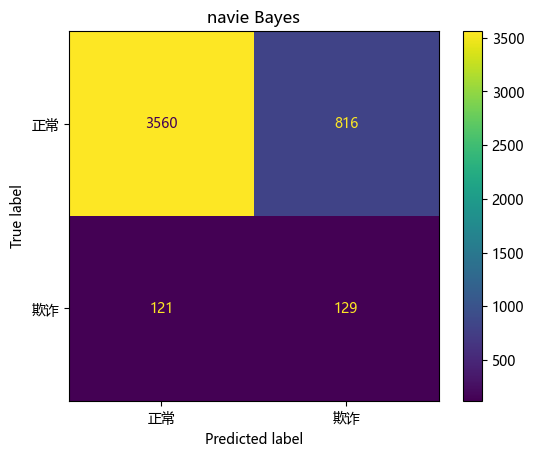

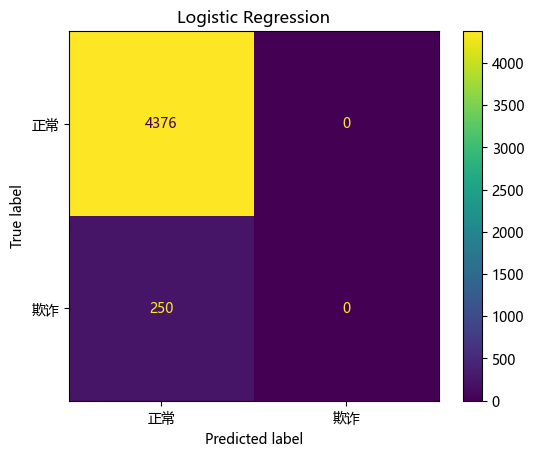

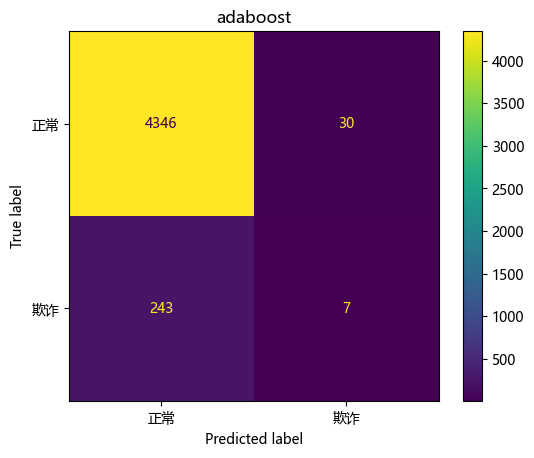

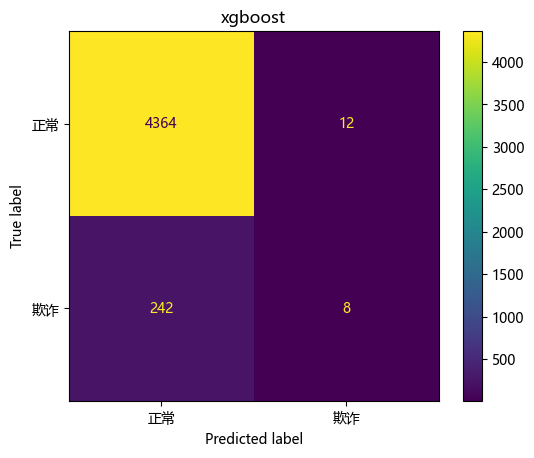

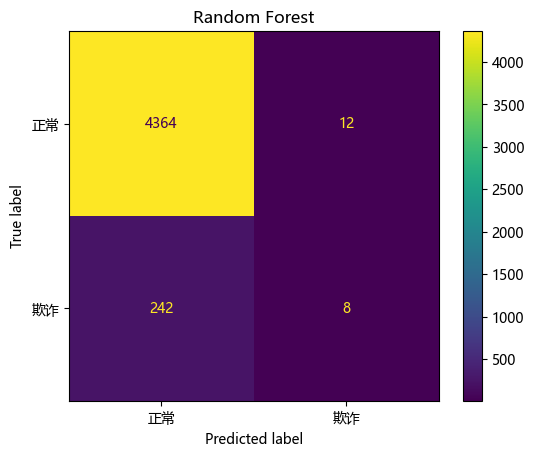

In [17]:
for clf,label in zip([clf1,clf2,clf3,clf4,clf5],['navie Bayes','Logistic Regression',
                                                'adaboost','xgboost','Random Forest']):
    clf=clf.fit(X=X_train,y=y_train)
    score=clf.predict_proba(X_test)[:,1]
    y_pred=clf.predict(X_test)
    
    #auc=cross_val_score(clf,X,y,cv=5,scoring='roc_auc')
    #accuracy=cross_val_score(clf,X,y,cv=5,scoring='accuracy')
    #precision=cross_val_score(clf,X,y,cv=5,scoring='precision')
    #recall=cross_val_score(clf,X,y,cv=5,scoring='recall')

    #print ('auc: %0.2f (+/- %0.2f) [%s]' %(auc.mean(), auc.std(), label))
    #print ('accuracy: %0.2f (+/- %0.2f) [%s]' %(accuracy.mean(), accuracy.std(), label))
    #print ('precision: %0.2f (+/- %0.2f) [%s]' %(precision.mean(), precision.std(), label))
    #print ('recall: %0.2f (+/- %0.2f) [%s]' %(recall.mean(), recall.std(), label))
    print('accuracy_score: %f [%s]' %(accuracy_score(y_test, y_pred), label))
    print('precision_score: %f [%s]' %(precision_score(y_test, y_pred), label))
    print('recall_score: %f [%s]' %(recall_score(y_test, y_pred), label))
    print('f1_score: %f [%s]' %(f1_score(y_test, y_pred), label))
    print('auc_score: %f [%s]' %(roc_auc_score(y_test, score), label))
    print("\n")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title(label)



vote_accuracy_score: 0.9280155642023347
vote_precision_score: 0.16260162601626016
vote_recall_score: 0.08
vote_f1_score: 0.10723860589812331
vote_roc_score: 0.7928286106032907


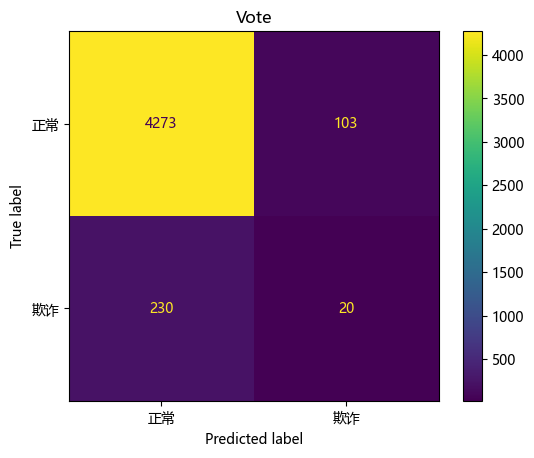

In [18]:
train_data_from_frame_voting([1, 1, 1])

vote_accuracy_score: 0.9280155642023347
vote_precision_score: 0.16260162601626016
vote_recall_score: 0.08
vote_f1_score: 0.10723860589812331
vote_roc_score: 0.7928825411334552


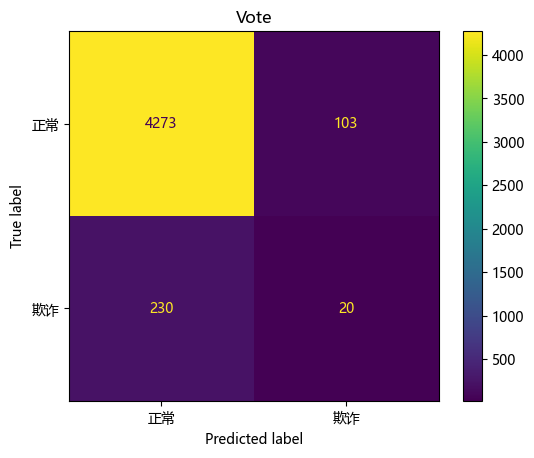

In [19]:
train_data_from_frame_voting([1, 0, 1])

vote_accuracy_score: 0.920881971465629
vote_precision_score: 0.13291139240506328
vote_recall_score: 0.084
vote_f1_score: 0.10294117647058823
vote_roc_score: 0.7845470749542961


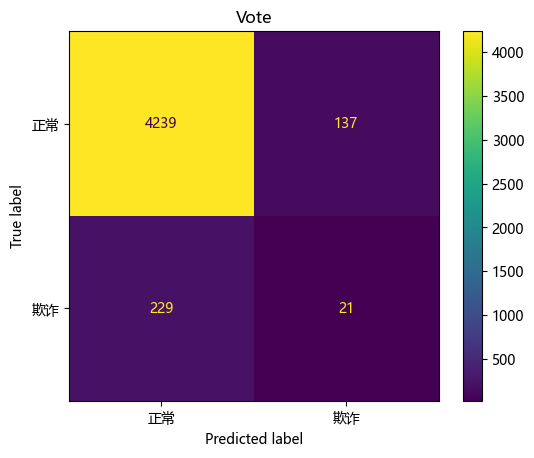

In [20]:
train_data_from_frame_voting([1, 200, 0])

vote_accuracy_score: 0.7086035451794207
vote_precision_score: 0.14171656686626746
vote_recall_score: 0.7859778597785978
vote_f1_score: 0.24013528748590754
vote_roc_score: 0.8124605471083414


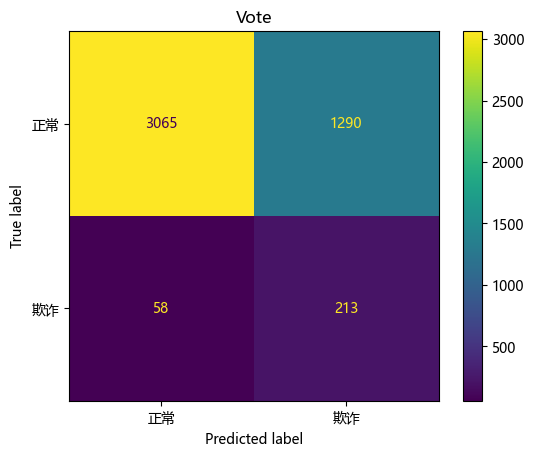

In [75]:
train_data_from_frame_voting([1, 200, 0.5])